In [7]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import math

In [8]:
from trnasimtools.serialize import SerializeTwoCodonMultiTranscript
import os

In [9]:
def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def concat_sims(path_pref, max_seed):
    df_master = pd.read_csv(f"{path_pref}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    return df_master
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = concat_sims(path, max_seed)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    #tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()
    tmp["delta"] = tmp.groupby(["species"])["protein"].diff(periods=8)
    tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

def get_average_protein_no_delta(path, time, max_seed):
    df_master = concat_sims(path, max_seed)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    tmp = df_master.groupby(["time", "species"])["protein"].mean().reset_index()
    #tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

In [72]:
# Now, run sweep of charging rates 10^1 to 5*10^2 & binding rates 10^3 to 10^5
ecol_mrna_composition = [(x/100, round(1 - (x/100), 2)) for x in range(1, 100)]

time_limit = 200
time_step = 5
transcript_lens = [1000]
cellular_transcript_copy_number = 100
gfp_transcript_copy_number = 10
ribosome_copy_number = 500
total_trna = 2500
#ecol_rbs_rate = [100000.0]
ecol_rbs_rates = [1000.0, 5000.0, 10000.0, 50000.0, 100000.0]
ribosome_binding_rate = 0.001
trna_charging_rates = [10.0, 50.0, 100.0, 250.0, 500.0, 1000.0, 5000.0]
transcript_names = ["cellularProtein", "GFP"]
trna_composition = (0.7, 0.3)
ecol_mrna_composition = ecol_mrna_composition
gfp_mrna_compositions = [(0.7, 0.3)]
ribosome_speed = 3 
ribosome_footprint = 15

date = "feb-27-2024"

In [75]:
configs = os.listdir(f"../yaml/{date}")
codons = []
for config in configs:
    pref = float(config.split("_")[4])
    unpref = round(1 - pref, 2)
    codons.append((pref, unpref))

In [76]:
#trna_charging_rates = [10.0, 50.0, 100.0, 250.0, 500.0]
ecol_mrna_composition = codons[0:55]

df_master = None
for ecol_rbs_rate in ecol_rbs_rates:
    df_rbs = None
    for comp in ecol_mrna_composition:
        df_comp = None
        for codons in gfp_mrna_compositions:
            df_codon = None
            for chrg_rate in trna_charging_rates:
                path = f"../output/{date}/two_codon_multi_transcript_{comp[0]}_{comp[1]}_0.7_0.3_0.7_0.3" + \
                       f"_{cellular_transcript_copy_number}_{gfp_transcript_copy_number}_{ribosome_copy_number}_{total_trna}" + \
                       f"_{ecol_rbs_rate}_0.001_{chrg_rate}_{chrg_rate}"
                tmp = get_average_protein(path, 0.5, 200, 3)
                tmp["charging_rate"] = chrg_rate
                tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
                if df_codon is not None:
                    df_codon = df_codon.append(tmp, ignore_index=True)
                else:
                    df_codon = tmp
            df_codon["codon"] = float(codons[0])
            if df_comp is not None:
                df_comp = df_comp.append(df_codon, ignore_index=True)
            else:
                df_comp = df_codon
        df_comp["ecol_comp"] = comp[0]
        if df_rbs is not None:
            df_rbs = df_rbs.append(df_comp, ignore_index=True)
        else:
            df_rbs = df_comp
    df_rbs["rbs_rate"] = ecol_rbs_rate
    if df_master is not None:
        df_master = df_master.append(df_rbs, ignore_index=True)
    else:
        df_master = df_rbs

df_master = df_master[(df_master.time == 200.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)

/tmp/ipykernel_403893/1584340.py:51: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()


In [77]:
df_copy = df_master.copy()

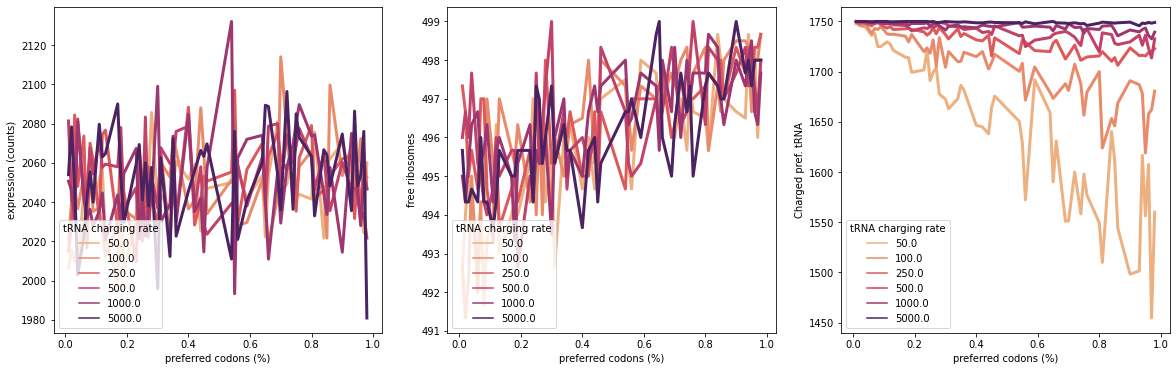

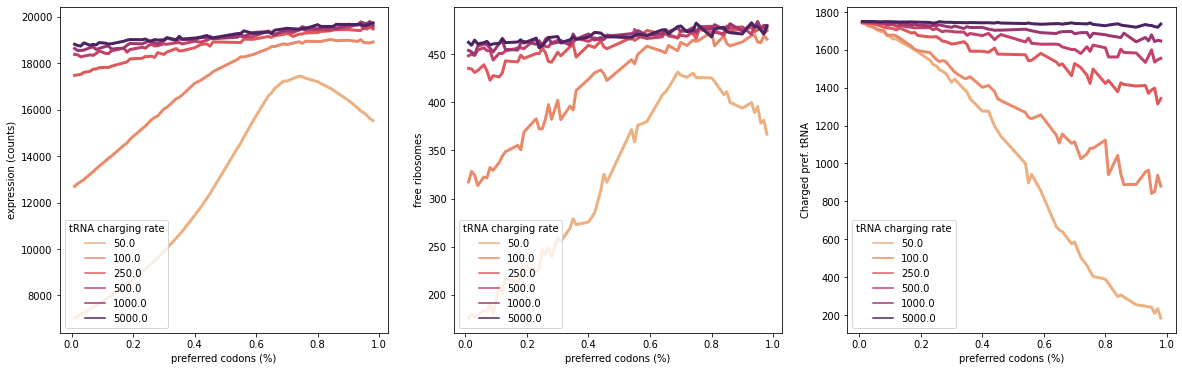

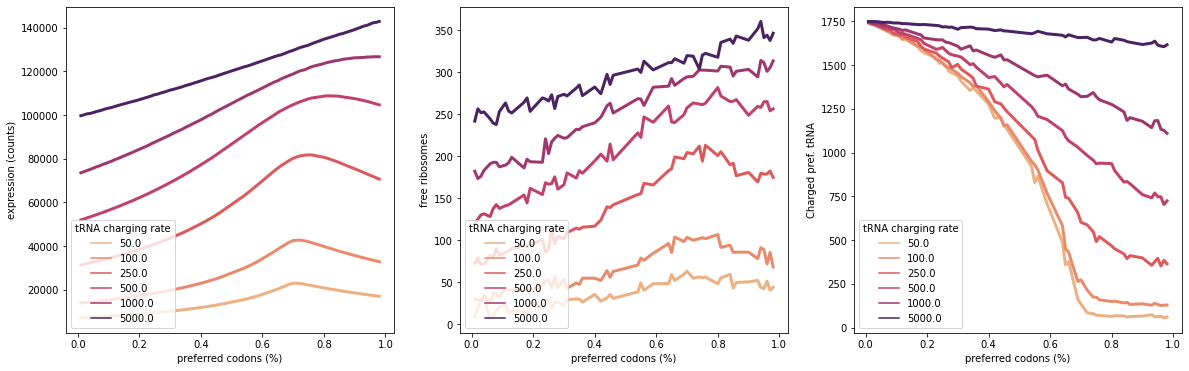

In [79]:
#ecol_rbs_rates = [1000.0, 5000.0, 10000.0, 50000.0, 100000.0]
ecol_rbs_rates_ = [1000.0, 10000.0, 100000.0] # now we can skip intermediate rates
 
for i in ecol_rbs_rates_:
    df_master = df_copy[(df_copy.rbs_rate == i)]
    df_master = df_master[(df_master.charging_rate > 10.0)]
    norm = LogNorm()
    rcParams['figure.figsize'] = [20, 6]
    fig, ax = plt.subplots(1, 3)

    df = df_master[(df_master.species == "cellularProtein")]
    g1 = sns.lineplot(data=df, x = "ecol_comp", y = "protein", hue="charging_rate", linewidth=3, hue_norm=norm, palette="flare", ax=ax[0])
    g1.set_xlabel("preferred codons (%)")
    g1.set_ylabel("expression (counts)")
    g1.legend(title="tRNA charging rate", loc="lower left")

    norm = LogNorm()
    df = df_master[(df_master.species == "free ribosome")]
    g2 = sns.lineplot(data=df, x = "ecol_comp", y = "protein", hue="charging_rate", linewidth=3, hue_norm=norm, palette="flare", ax=ax[1])
    g2.set_xlabel("preferred codons (%)")
    g2.set_ylabel("free ribosomes")
    g2.legend(title="tRNA charging rate", loc="lower left")

    norm = LogNorm()
    df = df_master[(df_master.species == "TTT_charged")]
    g3 = sns.lineplot(data=df, x = "ecol_comp", y = "protein", hue="charging_rate", linewidth=3, hue_norm=norm, palette="flare", ax=ax[2])
    g3.set_xlabel("preferred codons (%)")
    g3.set_ylabel("Charged pref. tRNA")
    g3.legend(title="tRNA charging rate", loc="lower left")

    plt.show()

In [62]:
plt.show(1)

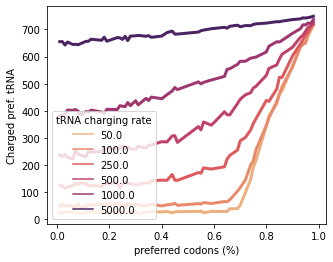

In [81]:
rcParams['figure.figsize'] = [5, 4]

df_master = df_copy[(df_copy.rbs_rate == 100000.0)]
df_master = df_master[(df_master.charging_rate > 10.0)]

norm = LogNorm()
df = df_master[(df_master.species == "ATA_charged")]
g = sns.lineplot(data=df, x = "ecol_comp", y = "protein", hue="charging_rate", linewidth=3, hue_norm=norm, palette="flare")
g.set_xlabel("preferred codons (%)")
g.set_ylabel("Charged pref. tRNA")
g.legend(title="tRNA charging rate", loc="lower left")